/var/folders/xn/wjzsc54j30q1_1ylc9gg8vth0000gn/T/ipykernel_23978/2912858732.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Diabeto indikatorius', group_keys=False).apply(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and

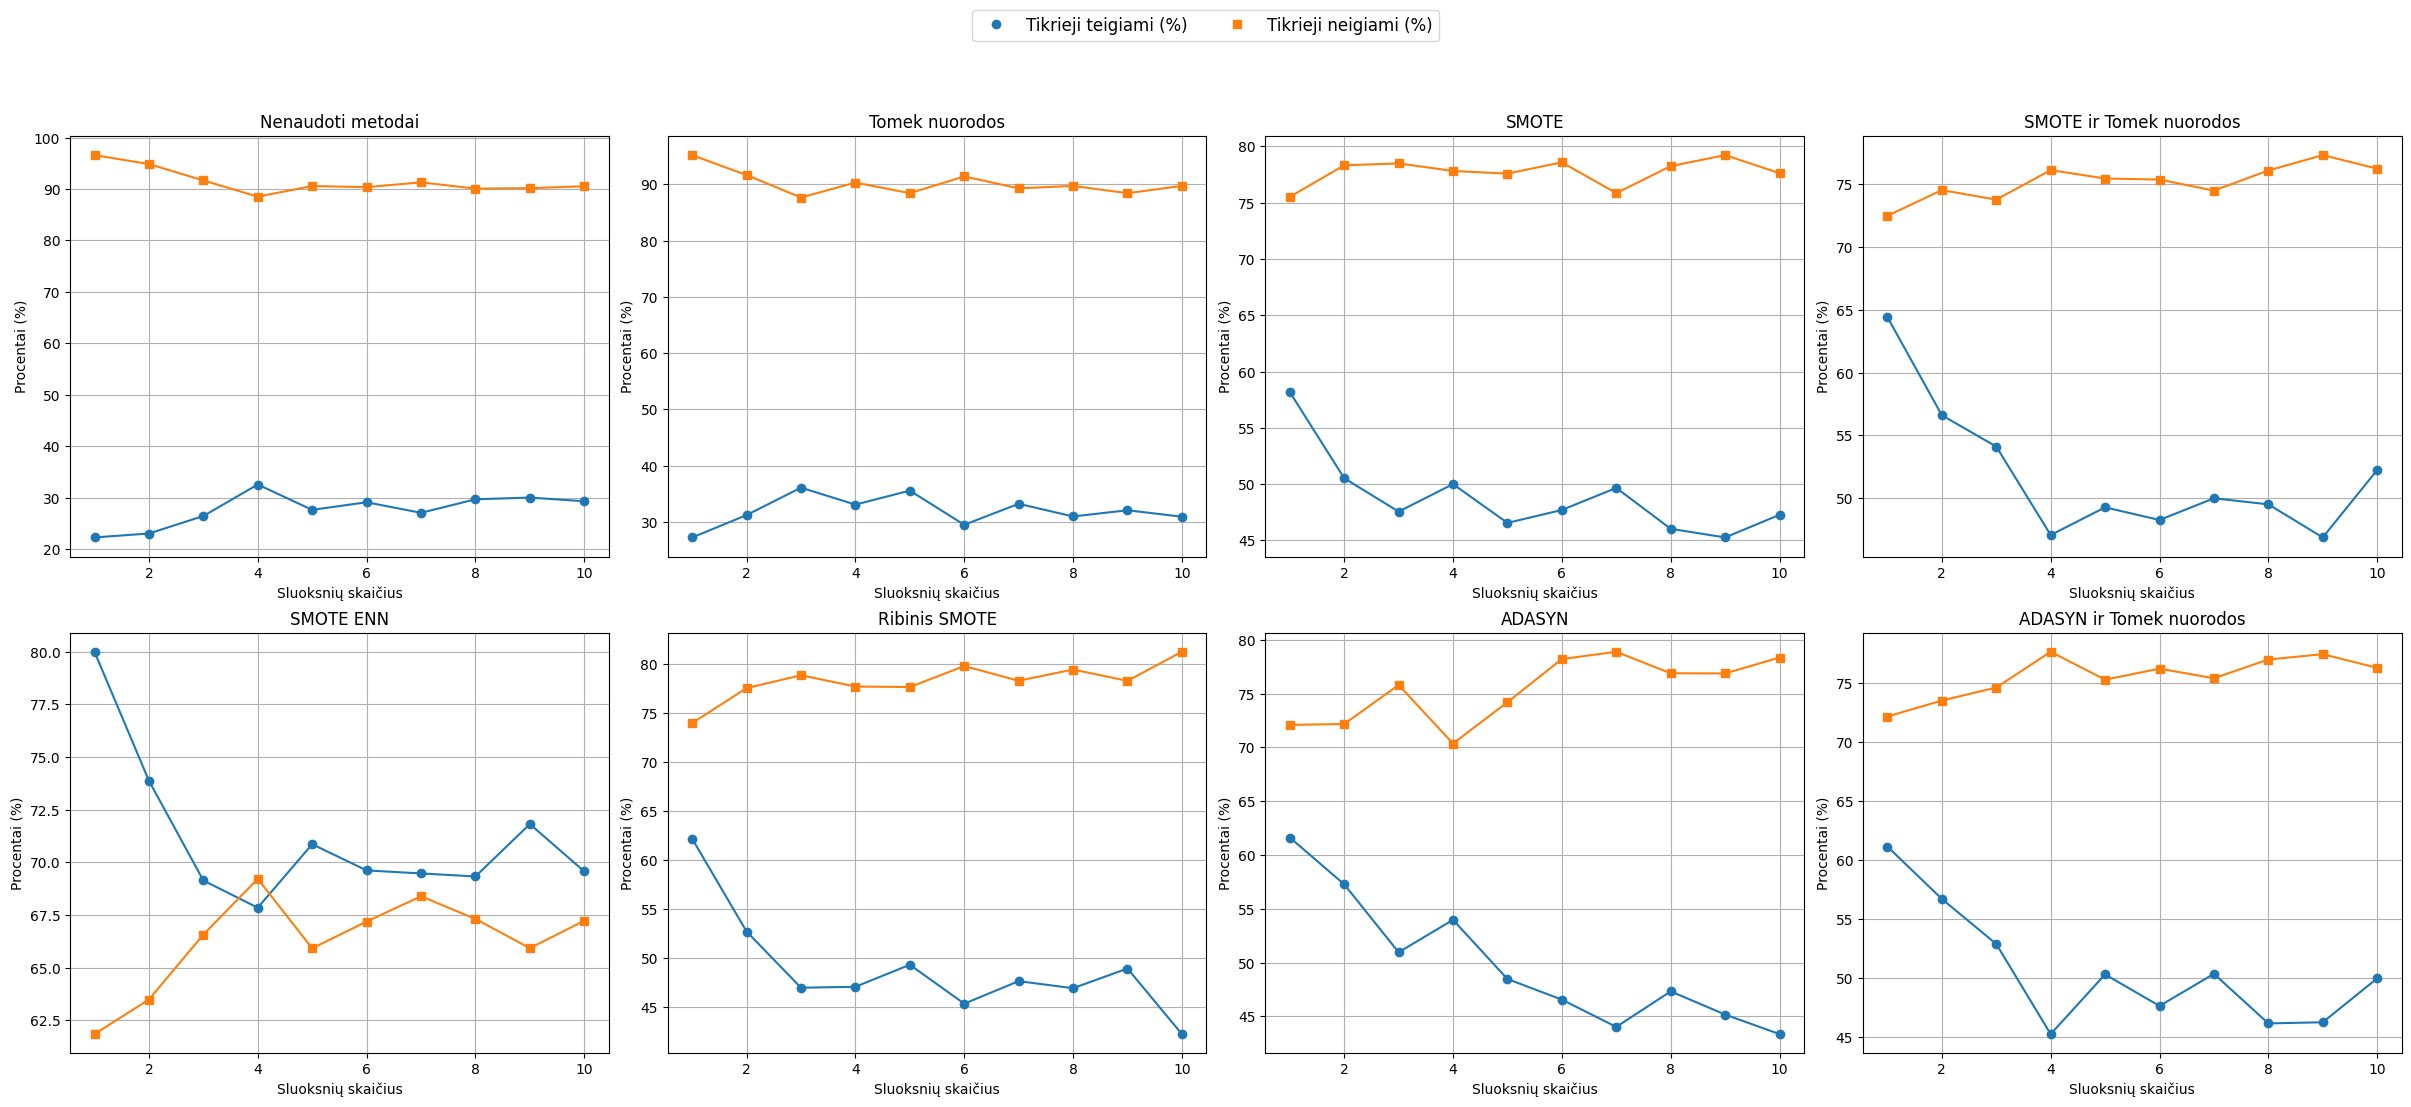

/var/folders/xn/wjzsc54j30q1_1ylc9gg8vth0000gn/T/ipykernel_23978/2912858732.py:128: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig2.subplots_adjust(top=0.88)


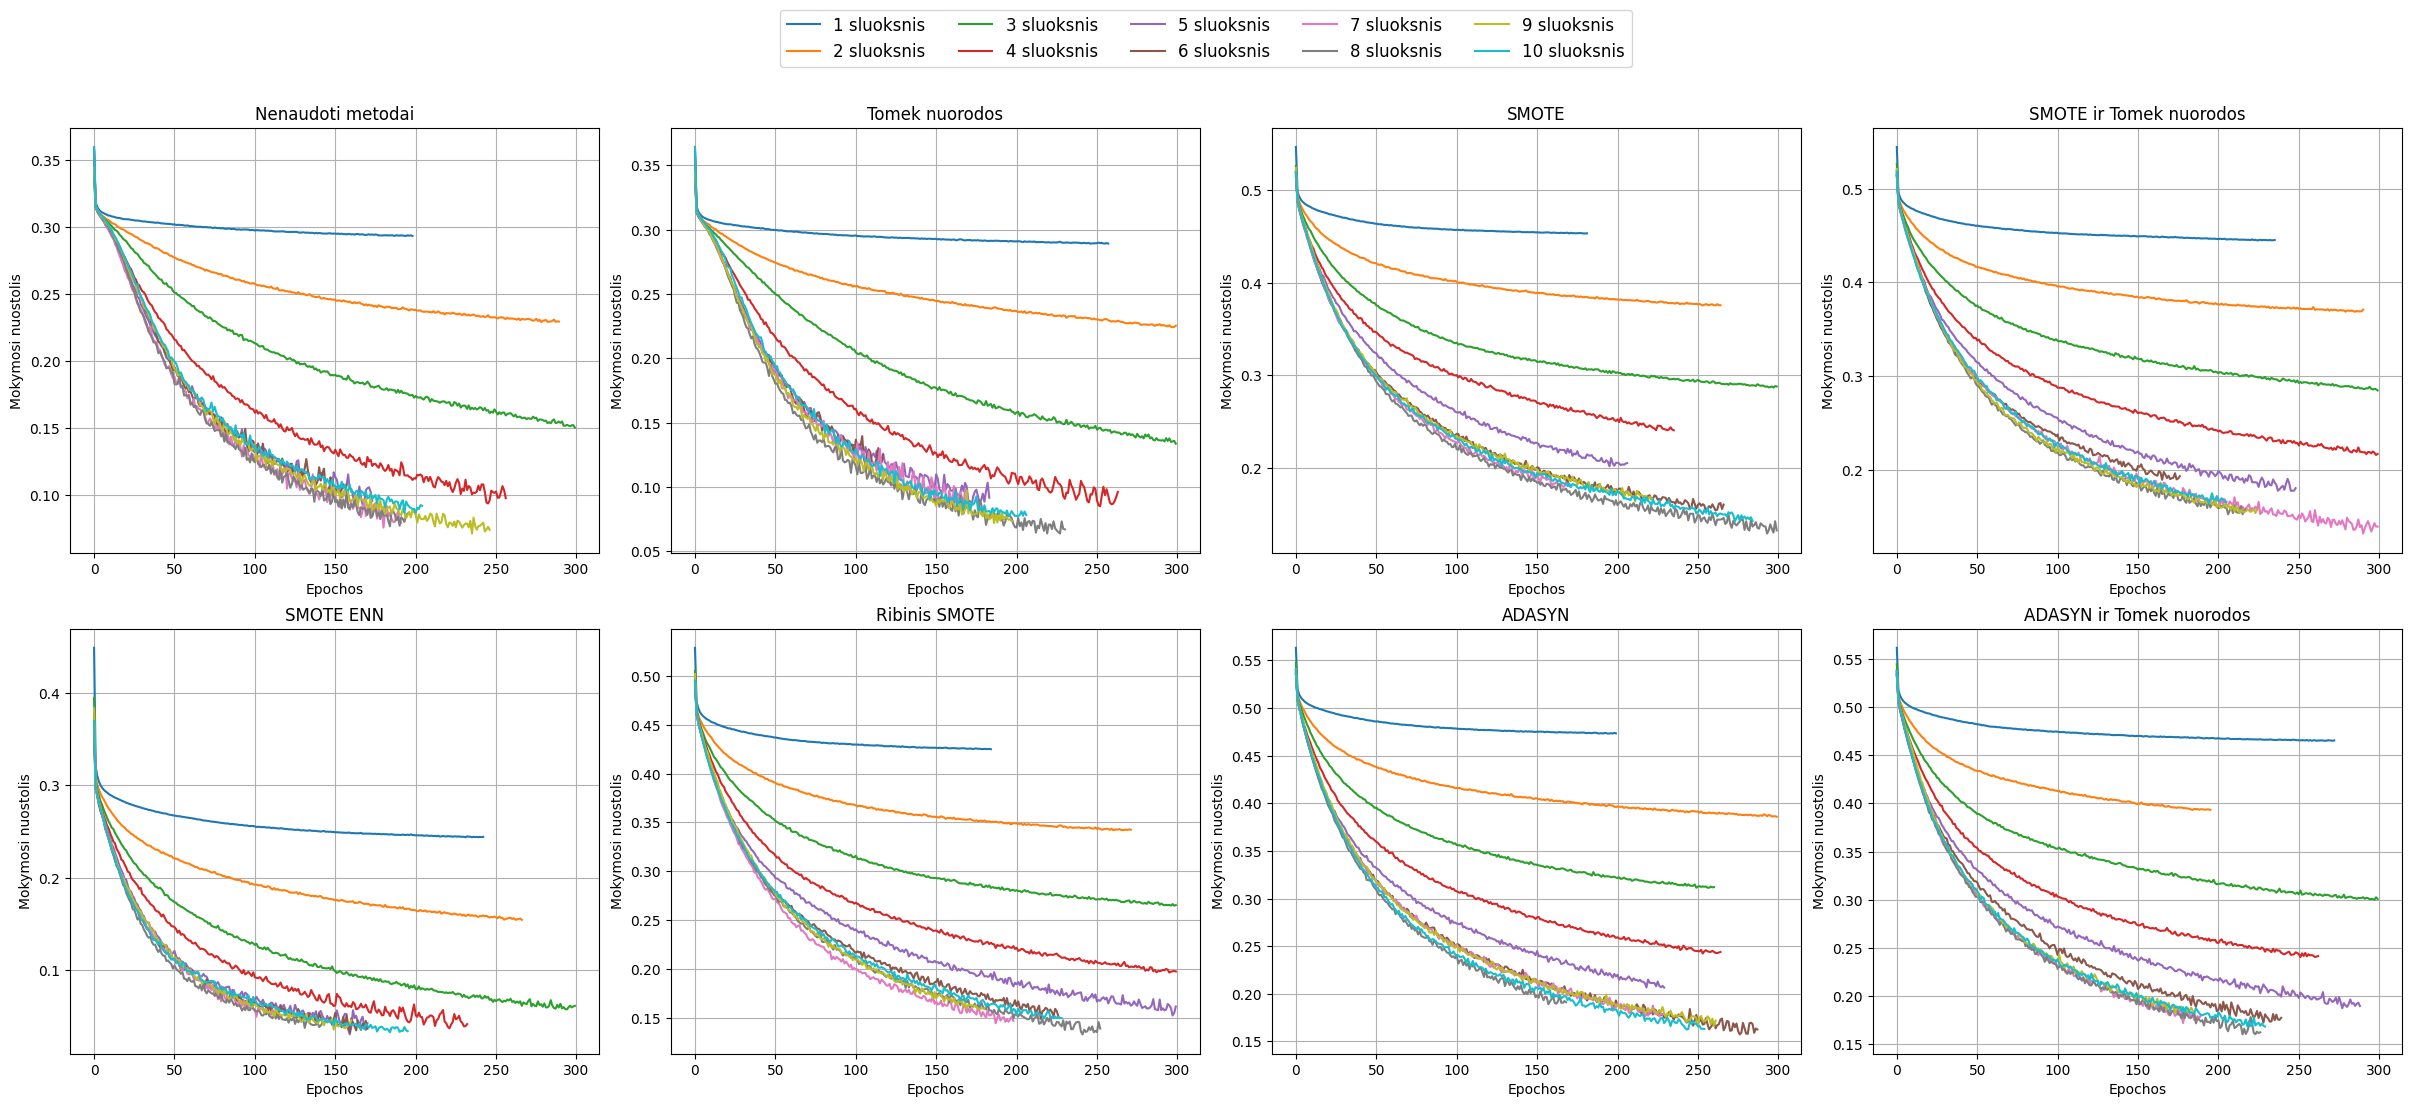

In [ ]:
# MLP klasifikavimo rezultatai keičiant paslėptų sluoksnių skaičių
# Mokymosi nuostolių analizė pagal MLP gylį naudojant po 50 neuronų sluoksnyje
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from matplotlib.lines import Line2D


df = pd.read_csv('cdc_diabetes_data.csv', encoding='utf-8-sig')
df.drop(columns=['ID'], inplace=True)
X = df.drop(columns=['Diabeto indikatorius'])
y = df['Diabeto indikatorius']

methods = [
    (None, "Nenaudoti metodai"),
    (TomekLinks(), "Tomek nuorodos"),
    (SMOTE(sampling_strategy=0.99, random_state=7), "SMOTE"),
    ((SMOTE(sampling_strategy=0.99, random_state=7), TomekLinks()), "SMOTE ir Tomek nuorodos"),
    (SMOTEENN(sampling_strategy=0.99, random_state=7), "SMOTE ENN"),
    (BorderlineSMOTE(sampling_strategy=0.99, random_state=7), "Ribinis SMOTE"),
    (ADASYN(sampling_strategy=0.99, random_state=7), "ADASYN"),
    ((ADASYN(sampling_strategy=0.99, random_state=7), TomekLinks()), "ADASYN ir Tomek nuorodos"),
]

tp_results, tn_results, loss_results = [], [], []
titles = []

for sampler, title in methods:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=7, stratify=y
    )

    if sampler is None:
        X_res, y_res = X_train, y_train
    elif isinstance(sampler, tuple):
        X_res, y_res = sampler[0].fit_resample(X_train, y_train)
        X_res, y_res = sampler[1].fit_resample(X_res, y_res)
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_res = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test)

    tp_list, tn_list, loss_list = [], [], []
    for layer_count in range(1, 11):
        mlp = MLPClassifier(hidden_layer_sizes=(50,) * layer_count, max_iter=300, random_state=7)
        mlp.fit(X_res, y_res)
        preds = mlp.predict(X_test_scaled)

        cm = confusion_matrix(y_test, preds)
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        tp_list.append(cm_pct[1, 1])
        tn_list.append(cm_pct[0, 0])
        loss_list.append(mlp.loss_curve_)

    tp_results.append(tp_list)
    tn_results.append(tn_list)
    loss_results.append(loss_list)
    titles.append(title)


fig, axes = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes = axes.flatten()
layer_counts = list(range(1, 11))

for i in range(8):
    axes[i].plot(layer_counts, tp_results[i], marker='o', color='C0')
    axes[i].plot(layer_counts, tn_results[i], marker='s', color='C1')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Sluoksnių skaičius')
    axes[i].set_ylabel('Procentai (%)')
    axes[i].grid(True)

proxy_lines = [
    Line2D([0], [0], marker='o', color='C0', label='Tikrieji teigiami (%)', linestyle=''),
    Line2D([0], [0], marker='s', color='C1', label='Tikrieji neigiami (%)', linestyle='')
]
fig.legend(
    handles=proxy_lines,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10), 
    ncol=2,
    fontsize=12
)
fig.suptitle('', fontsize=16)

fig.subplots_adjust(top=0.88)

plt.savefig("diabetes_layers_50.png", dpi=300, bbox_inches='tight')
plt.show()


fig2, axes2 = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes2 = axes2.flatten()

for i in range(8):
    for L, lc in enumerate(loss_results[i], start=1):
        axes2[i].plot(lc, color=f'C{(L-1)%10}')
    axes2[i].set_title(titles[i])
    axes2[i].set_xlabel('Epochos')
    axes2[i].set_ylabel('Mokymosi nuostolis')
    axes2[i].grid(True)

loss_proxies = [
    Line2D([0], [0], color=f'C{(L-1)%10}', label=f'{L} sluoksnis')
    for L in layer_counts
]
fig2.legend(
    handles=loss_proxies,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10),
    ncol=5,
    fontsize=12
)
fig2.subplots_adjust(top=0.88)

#plt.savefig("diabetes_epoch_50.png", dpi=300, bbox_inches='tight')
plt.show()


/var/folders/xn/wjzsc54j30q1_1ylc9gg8vth0000gn/T/ipykernel_23978/1310022152.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Diabeto indikatorius', group_keys=False).apply(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and

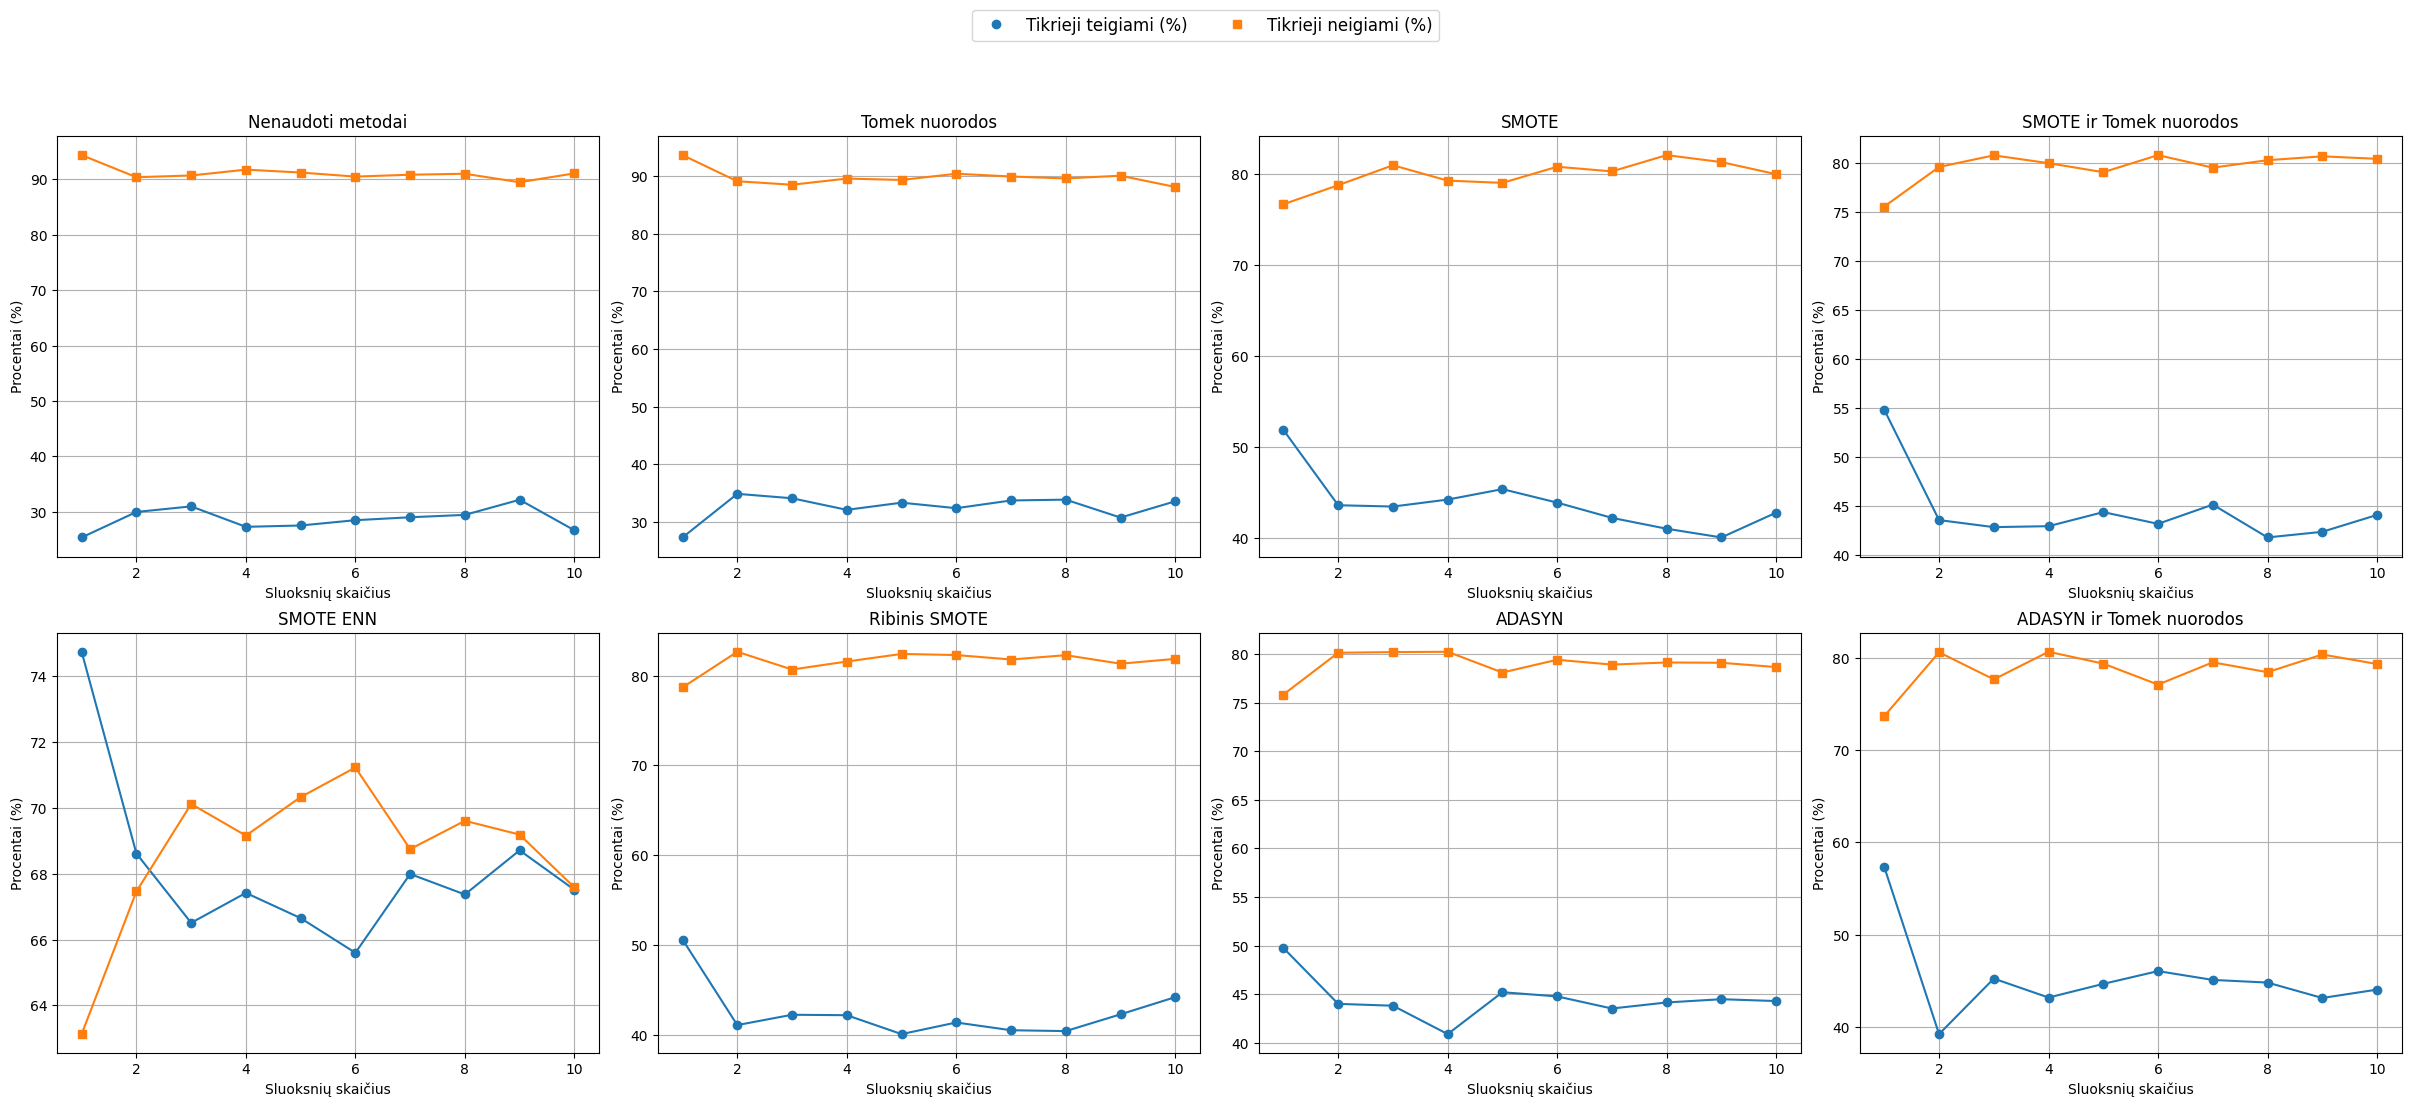

/var/folders/xn/wjzsc54j30q1_1ylc9gg8vth0000gn/T/ipykernel_23978/1310022152.py:128: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig2.subplots_adjust(top=0.88)


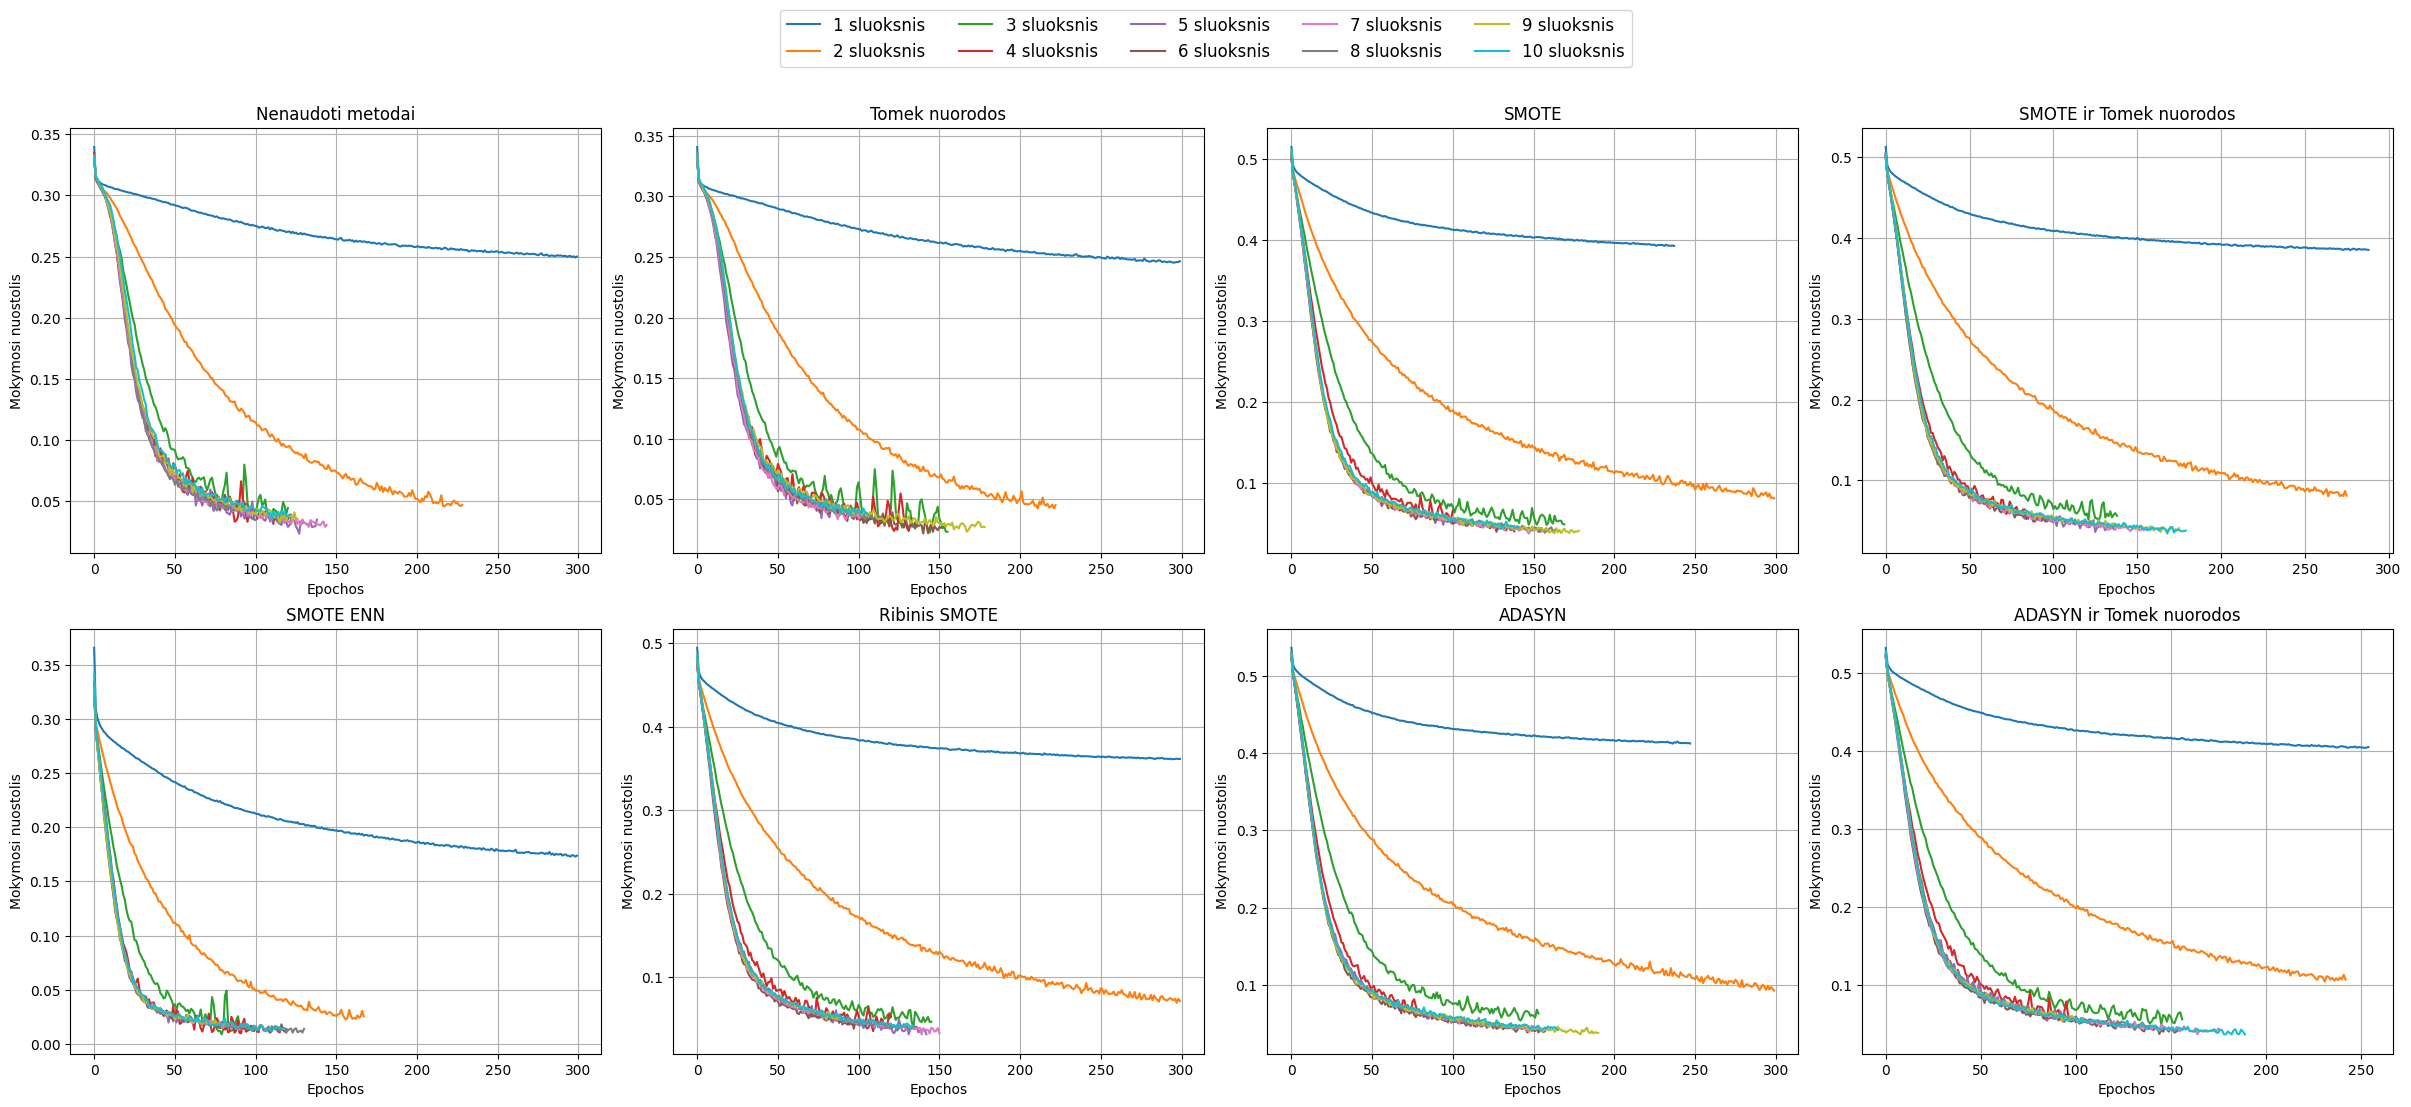

In [ ]:
# MLP klasifikavimo rezultatai keičiant paslėptų sluoksnių skaičių
# Mokymosi nuostolių analizė pagal MLP gylį naudojant po 150 neuronų sluoksnyje
# 150.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from matplotlib.lines import Line2D


df = pd.read_csv('cdc_diabetes_data.csv', encoding='utf-8-sig')
df.drop(columns=['ID'], inplace=True)

X = df.drop(columns=['Diabeto indikatorius'])
y = df['Diabeto indikatorius']

methods = [
    (None, "Nenaudoti metodai"),
    (TomekLinks(), "Tomek nuorodos"),
    (SMOTE(sampling_strategy=0.99, random_state=7), "SMOTE"),
    ((SMOTE(sampling_strategy=0.99, random_state=7), TomekLinks()), "SMOTE ir Tomek nuorodos"),
    (SMOTEENN(sampling_strategy=0.99, random_state=7), "SMOTE ENN"),
    (BorderlineSMOTE(sampling_strategy=0.99, random_state=7), "Ribinis SMOTE"),
    (ADASYN(sampling_strategy=0.99, random_state=7), "ADASYN"),
    ((ADASYN(sampling_strategy=0.99, random_state=7), TomekLinks()), "ADASYN ir Tomek nuorodos"),
]

tp_results, tn_results, loss_results = [], [], []
titles = []

for sampler, title in methods:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=7, stratify=y
    )

    if sampler is None:
        X_res, y_res = X_train, y_train
    elif isinstance(sampler, tuple):
        X_res, y_res = sampler[0].fit_resample(X_train, y_train)
        X_res, y_res = sampler[1].fit_resample(X_res, y_res)
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_res = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test)

    tp_list, tn_list, loss_list = [], [], []
    for layer_count in range(1, 11):
        mlp = MLPClassifier(hidden_layer_sizes=(150,) * layer_count, max_iter=300, random_state=7)
        mlp.fit(X_res, y_res)
        preds = mlp.predict(X_test_scaled)

        cm = confusion_matrix(y_test, preds)
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        tp_list.append(cm_pct[1, 1])
        tn_list.append(cm_pct[0, 0])
        loss_list.append(mlp.loss_curve_)

    tp_results.append(tp_list)
    tn_results.append(tn_list)
    loss_results.append(loss_list)
    titles.append(title)


fig, axes = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes = axes.flatten()
layer_counts = list(range(1, 11))

for i in range(8):
    axes[i].plot(layer_counts, tp_results[i], marker='o', color='C0')
    axes[i].plot(layer_counts, tn_results[i], marker='s', color='C1')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Sluoksnių skaičius')
    axes[i].set_ylabel('Procentai (%)')
    axes[i].grid(True)

proxy_lines = [
    Line2D([0], [0], marker='o', color='C0', label='Tikrieji teigiami (%)', linestyle=''),
    Line2D([0], [0], marker='s', color='C1', label='Tikrieji neigiami (%)', linestyle='')
]
fig.legend(
    handles=proxy_lines,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10), 
    ncol=2,
    fontsize=12
)
fig.suptitle('', fontsize=16)

fig.subplots_adjust(top=0.88)

plt.savefig("diabetes_layers_150.png", dpi=300, bbox_inches='tight')
plt.show()


fig2, axes2 = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes2 = axes2.flatten()

for i in range(8):
    for L, lc in enumerate(loss_results[i], start=1):
        axes2[i].plot(lc, color=f'C{(L-1)%10}')
    axes2[i].set_title(titles[i])
    axes2[i].set_xlabel('Epochos')
    axes2[i].set_ylabel('Mokymosi nuostolis')
    axes2[i].grid(True)

loss_proxies = [
    Line2D([0], [0], color=f'C{(L-1)%10}', label=f'{L} sluoksnis')
    for L in layer_counts
]
fig2.legend(
    handles=loss_proxies,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10),
    ncol=5,
    fontsize=12
)
fig2.subplots_adjust(top=0.88)

#plt.savefig("diabetes_epoch_150.png", dpi=300, bbox_inches='tight')
plt.show()


/var/folders/xn/wjzsc54j30q1_1ylc9gg8vth0000gn/T/ipykernel_23978/865587497.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Diabeto indikatorius', group_keys=False).apply(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and 

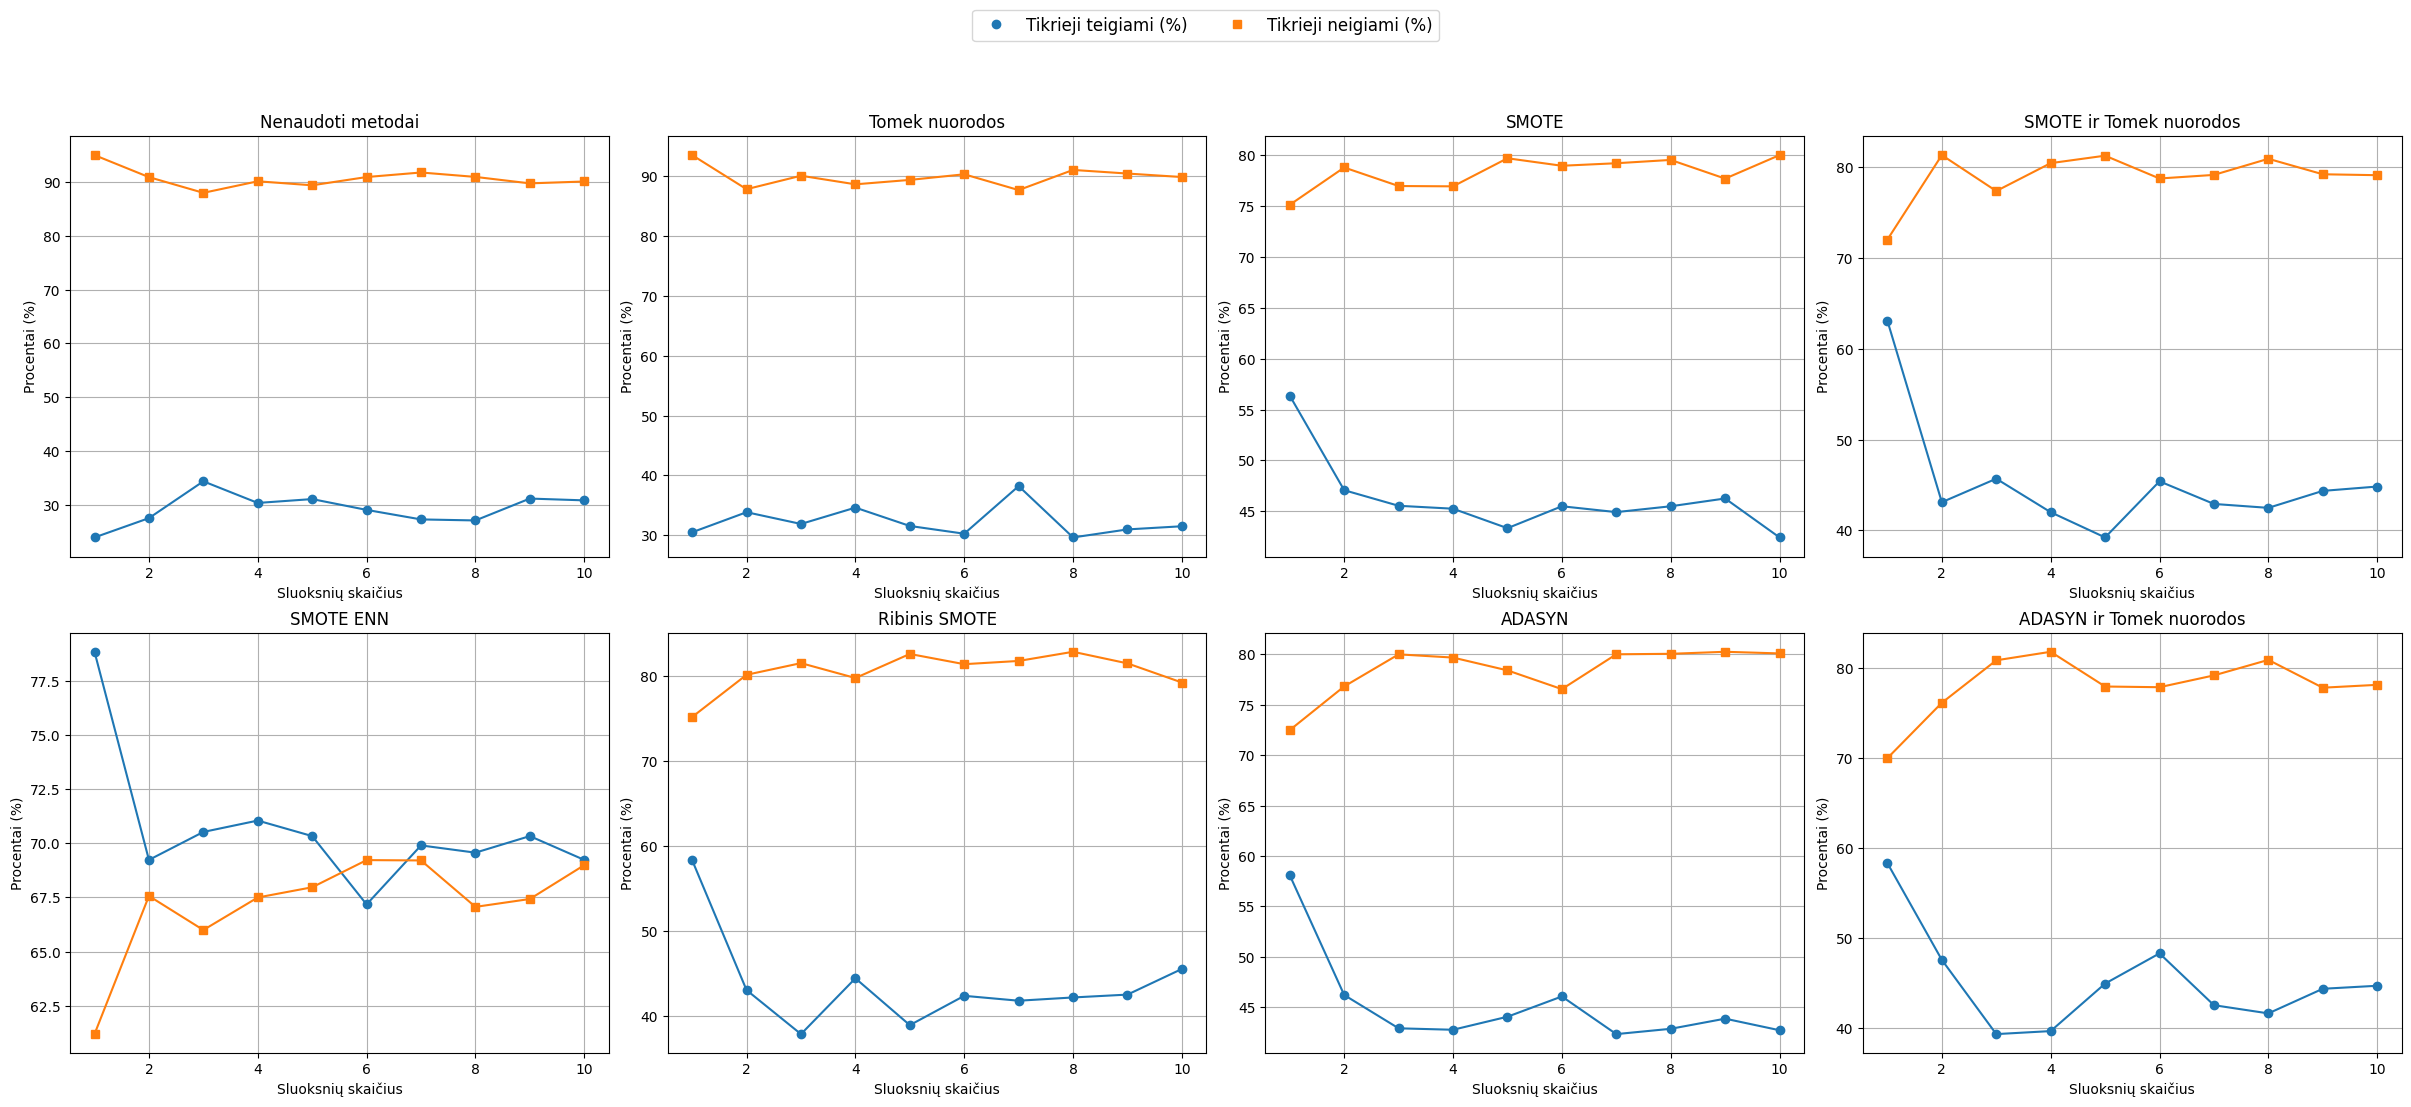

/var/folders/xn/wjzsc54j30q1_1ylc9gg8vth0000gn/T/ipykernel_23978/865587497.py:128: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig2.subplots_adjust(top=0.88)


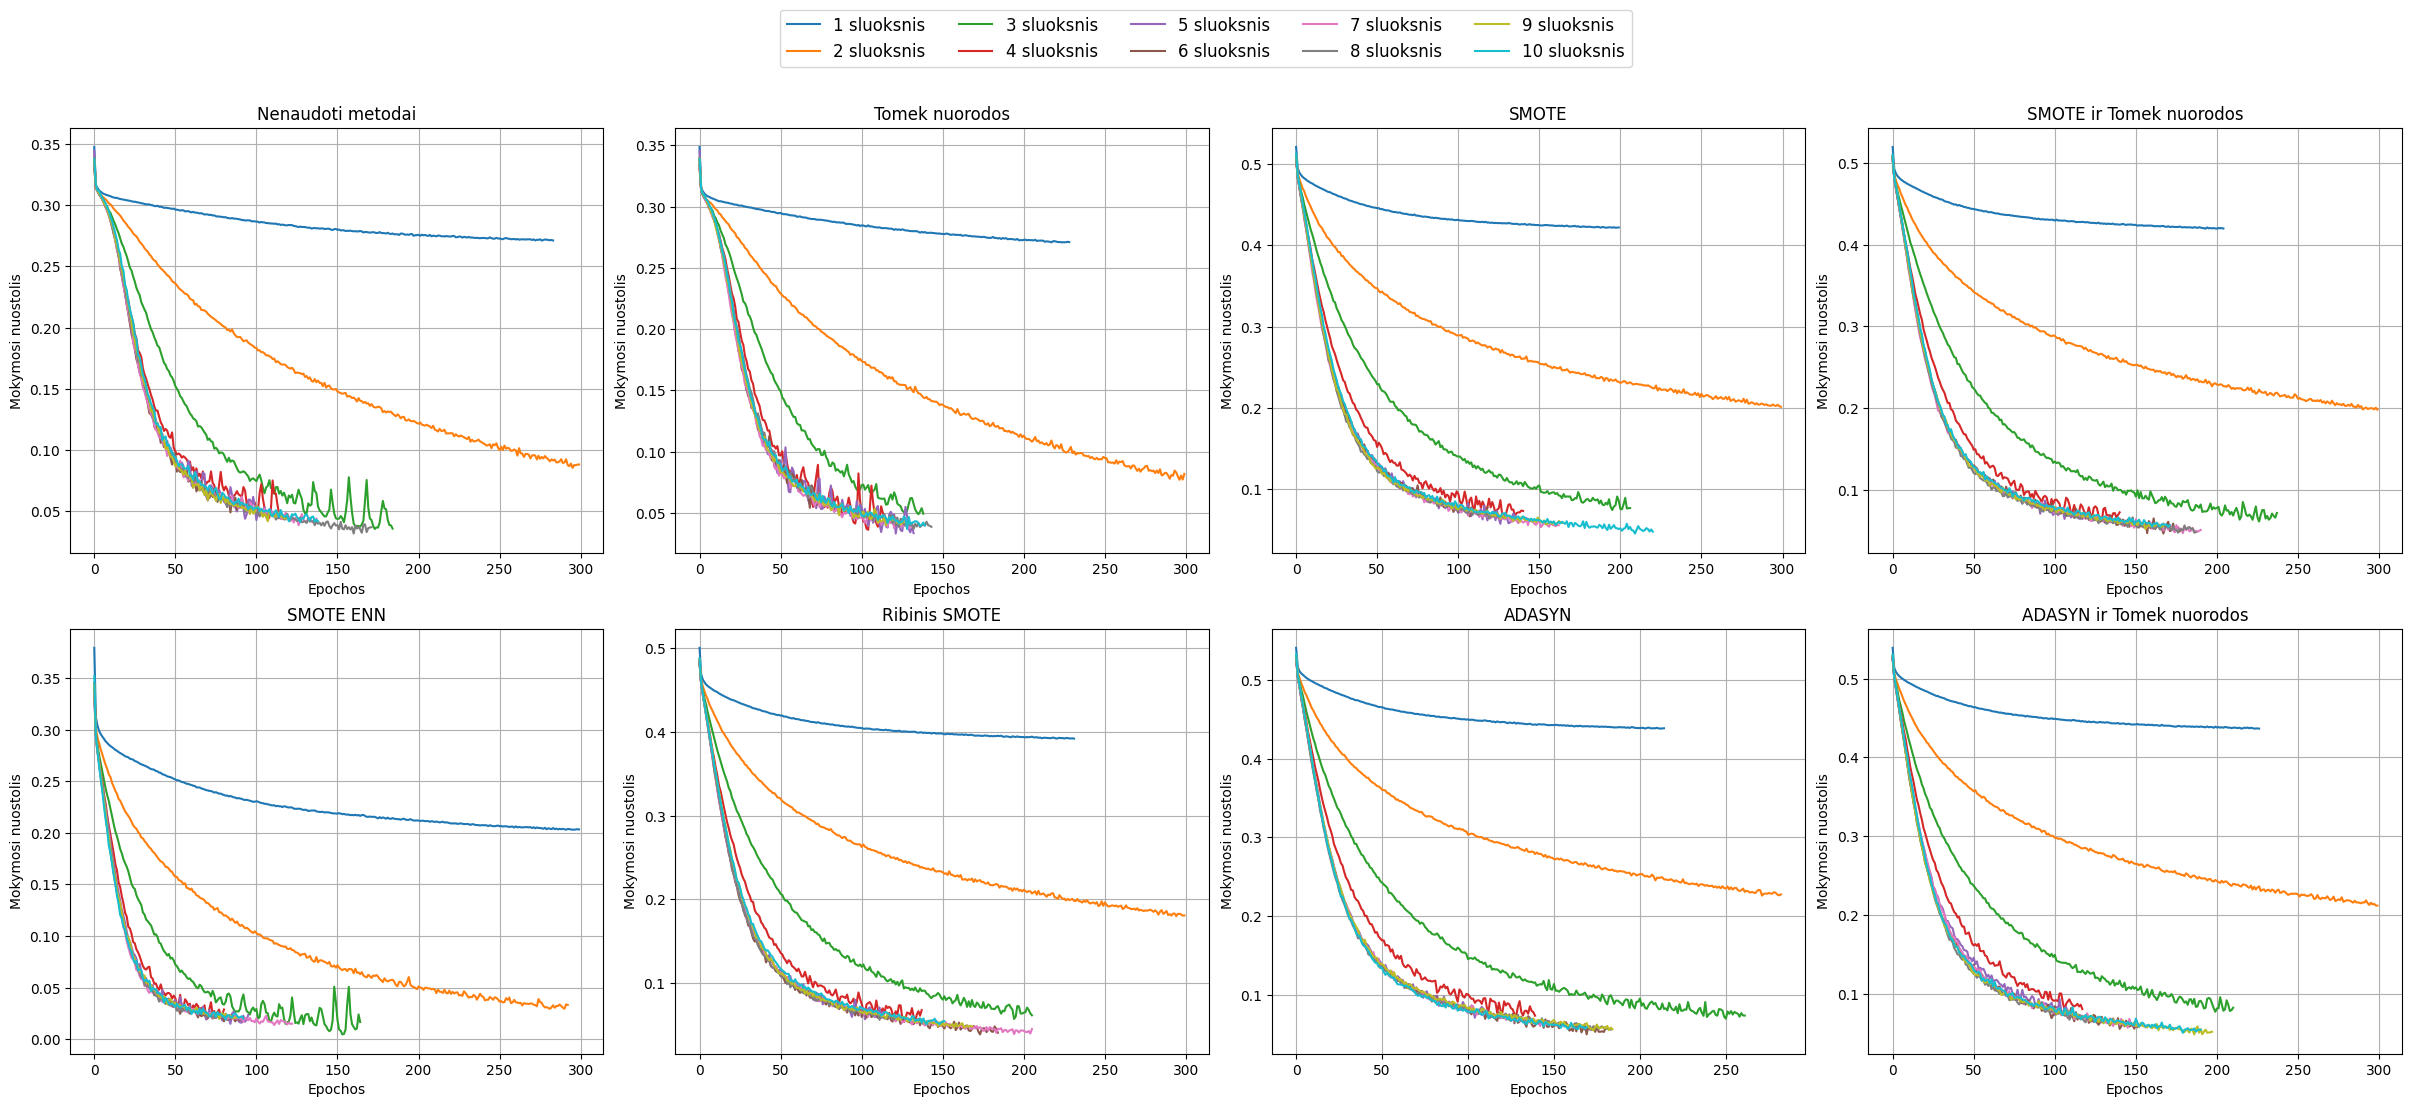

In [ ]:
# MLP klasifikavimo rezultatai keičiant paslėptų sluoksnių skaičių
# Mokymosi nuostolių analizė pagal MLP gylį naudojant po 100 neuronų sluoksnyje
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from matplotlib.lines import Line2D


df = pd.read_csv('cdc_diabetes_data.csv', encoding='utf-8-sig')
df.drop(columns=['ID'], inplace=True)

X = df.drop(columns=['Diabeto indikatorius'])
y = df['Diabeto indikatorius']

methods = [
    (None, "Nenaudoti metodai"),
    (TomekLinks(), "Tomek nuorodos"),
    (SMOTE(sampling_strategy=0.99, random_state=7), "SMOTE"),
    ((SMOTE(sampling_strategy=0.99, random_state=7), TomekLinks()), "SMOTE ir Tomek nuorodos"),
    (SMOTEENN(sampling_strategy=0.99, random_state=7), "SMOTE ENN"),
    (BorderlineSMOTE(sampling_strategy=0.99, random_state=7), "Ribinis SMOTE"),
    (ADASYN(sampling_strategy=0.99, random_state=7), "ADASYN"),
    ((ADASYN(sampling_strategy=0.99, random_state=7), TomekLinks()), "ADASYN ir Tomek nuorodos"),
]

tp_results, tn_results, loss_results = [], [], []
titles = []

for sampler, title in methods:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=7, stratify=y
    )

    if sampler is None:
        X_res, y_res = X_train, y_train
    elif isinstance(sampler, tuple):
        X_res, y_res = sampler[0].fit_resample(X_train, y_train)
        X_res, y_res = sampler[1].fit_resample(X_res, y_res)
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_res = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test)

    tp_list, tn_list, loss_list = [], [], []
    for layer_count in range(1, 11):
        mlp = MLPClassifier(hidden_layer_sizes=(100,) * layer_count, max_iter=300, random_state=7)
        mlp.fit(X_res, y_res)
        preds = mlp.predict(X_test_scaled)

        cm = confusion_matrix(y_test, preds)
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        tp_list.append(cm_pct[1, 1])
        tn_list.append(cm_pct[0, 0])
        loss_list.append(mlp.loss_curve_)

    tp_results.append(tp_list)
    tn_results.append(tn_list)
    loss_results.append(loss_list)
    titles.append(title)


fig, axes = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes = axes.flatten()
layer_counts = list(range(1, 11))

for i in range(8):
    axes[i].plot(layer_counts, tp_results[i], marker='o', color='C0')
    axes[i].plot(layer_counts, tn_results[i], marker='s', color='C1')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Sluoksnių skaičius')
    axes[i].set_ylabel('Procentai (%)')
    axes[i].grid(True)

proxy_lines = [
    Line2D([0], [0], marker='o', color='C0', label='Tikrieji teigiami (%)', linestyle=''),
    Line2D([0], [0], marker='s', color='C1', label='Tikrieji neigiami (%)', linestyle='')
]
fig.legend(
    handles=proxy_lines,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10), 
    ncol=2,
    fontsize=12
)
fig.suptitle('', fontsize=16)

fig.subplots_adjust(top=0.88)

plt.savefig("diabetes_layers_100.png", dpi=300, bbox_inches='tight')
plt.show()


fig2, axes2 = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes2 = axes2.flatten()

for i in range(8):
    for L, lc in enumerate(loss_results[i], start=1):
        axes2[i].plot(lc, color=f'C{(L-1)%10}')
    axes2[i].set_title(titles[i])
    axes2[i].set_xlabel('Epochos')
    axes2[i].set_ylabel('Mokymosi nuostolis')
    axes2[i].grid(True)

loss_proxies = [
    Line2D([0], [0], color=f'C{(L-1)%10}', label=f'{L} sluoksnis')
    for L in layer_counts
]
fig2.legend(
    handles=loss_proxies,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10),
    ncol=5,
    fontsize=12
)
fig2.subplots_adjust(top=0.88)

#plt.savefig("diabetes_epoch_100.png", dpi=300, bbox_inches='tight')
plt.show()
